# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [1]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxboard import SummaryWriter
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [4]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [5]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [6]:
# make tqdm jupyter friendly
from tqdm import tqdm_notebook as tqdm
# for .progress_apply() we have to hack it like this?
tqdm().pandas()

In [7]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [8]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [9]:
with Timer("read cross"):
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id')

with Timer("read within"):
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    # within_test_df = pd.read_csv(data_within_path.format('test'),
    #                              quotechar='"',
    #                              quoting=csv.QUOTE_ALL,
    #                              encoding='utf-8',
    #                              escapechar='\\',
    #                              doublequote=True,  # <-- change, "" as quote escape in text?
    #                              index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id')

Time for [read cross]: 0:00:00.857154
Time for [read within]: 0:00:00.841385


In [ ]:
! head -n 5 data/same-side-classification/within-topic/test.csv

In [10]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.progress_apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.progress_apply(add_tag, axis=1)


Time for [tag cross traindev]: 0:00:32.995948



Time for [tag cross test]: 0:00:03.248861



Time for [tag within traindev]: 0:00:34.442718



Time for [tag within test]: 0:00:01.873477


### Get an overview about each dataset

In [11]:
# requires nltk  wordtokenize
# from nltk.tokenize import sent_tokenize, word_tokenize
# model uses BERT Tokenizer ...

def get_overview(df, task='same-side', class_name='is_same_side'):
    # Total instance numbers
    total = len(df)
    print("Task: ", task)
    print('=' * 40, '\n')

    print('Total instances: ', total)
    print('\n')

    print('For each topic:')
    for tag, tag_df in df.groupby(['tag']):
        print(tag, ': ', len(tag_df), ' instances')
        if class_name in df.columns:
            for is_same_side, side_df in tag_df.groupby([class_name]):
                print('\t\t', is_same_side, ': ', len(side_df), ' instances')
    print('\n')

    if class_name in df.columns:
        print('For each class value:')
        for class_value, class_df in df.groupby([class_name]):
            print(class_value, ': ', len(class_df), ' instances')
        print('\n')

    print('Unique argument1:', len(df['argument1'].unique()))
    print('Unique argument2:', len(df['argument2'].unique()))
    arguments = df['argument1'].values
    arguments = np.concatenate([arguments, df['argument2'].values])

    print('Unique total arguments:', len(set(list(arguments))), '\n')
    
    return

    print('-' * 40, '\n')

    arguments_length_lst = [
        len(word_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_length_lst.extend(
        [len(word_tokenize(x)) for x in df['argument2'].values])
    print('Words:')
    print('\tshortest argument:', min(arguments_length_lst), ' words')
    print('\tlongest argument:', max(arguments_length_lst), ' words')
    print('\targument average length:', np.mean(arguments_length_lst),
          ' words')

    arguments_sent_length_lst = [
        len(sent_tokenize(x)) for x in df['argument1'].values
    ]
    arguments_sent_length_lst.extend(
        [len(sent_tokenize(x)) for x in df['argument2'].values])
    print('Sentences:')
    print('\tshortest argument:', min(arguments_sent_length_lst), ' sentences')
    print('\tlongest argument:', max(arguments_sent_length_lst), ' sentences')
    print('\targument average length:', np.mean(arguments_sent_length_lst),
          ' sentences')

In [ ]:
with Timer("overview cross"):
    get_overview(cross_traindev_df)

In [ ]:
with Timer("overview within"):
    get_overview(within_traindev_df)

##### Count raw length

In [ ]:
def compute_arg_len(row):
    row['argument1_len'] = len(row['argument1'])
    row['argument2_len'] = len(row['argument2'])
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff']
    return row


cross_traindev_df = cross_traindev_df.progress_apply(compute_arg_len, axis=1)
within_traindev_df = within_traindev_df.progress_apply(compute_arg_len, axis=1)
cross_test_df = cross_test_df.progress_apply(compute_arg_len, axis=1)
within_test_df = within_test_df.progress_apply(compute_arg_len, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

In [ ]:
within_test_df.describe()

##### Tokenize and count tokens

In [ ]:
ctx = mx.cpu()
_, vocabulary = nlp.model.get_model('bert_12_768_12',
                                    dataset_name='book_corpus_wiki_en_uncased',
                                    pretrained=True, ctx=ctx, use_pooler=True,
                                    use_decoder=False, use_classifier=False)
bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
tokenizer = bert_tokenizer

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('punct')


# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff'])
    return row


cross_traindev_df = cross_traindev_df.progress_apply(tokenize_arguments, axis=1)
within_traindev_df = within_traindev_df.progress_apply(tokenize_arguments, axis=1)
cross_test_df = cross_test_df.progress_apply(tokenize_arguments, axis=1)
within_test_df = within_test_df.progress_apply(tokenize_arguments, axis=1)

In [ ]:
cross_traindev_df.describe()

In [ ]:
within_traindev_df.describe()

In [ ]:
within_test_df.describe()

In [ ]:
def plot_lengths(df, slicen=None, abs_diff=True, title=None):
    if df is None:
        print("no lengths to plot")
        return
    
    arg1_lens = df['argument1_len']
    arg2_lens = df['argument2_len']
    arg_diff_len = df['argument12_len_diff']
    
    if abs_diff:
        arg_diff_len = np.abs(arg_diff_len)
    
    if slicen is not None:
        arg1_lens = arg1_lens[slicen]
        arg2_lens = arg2_lens[slicen]
        arg_diff_len = arg_diff_len[slicen]

    x = np.arange(len(arg1_lens))  # arange/linspace

    plt.subplot(2, 1, 1)
    plt.plot(x, arg1_lens, label='argument1')  # Linie: '-', 'o-', '.-'
    plt.plot(x, arg2_lens, label='argument2')  # Linie: '-', 'o-', '.-'
    plt.legend()
    plt.title('Lengths of arguments' if not title else title)
    plt.ylabel('Lengths of arguments 1 and 2')

    plt.subplot(2, 1, 2)
    plt.plot(x, arg_diff_len)
    plt.xlabel('Index')
    plt.ylabel('Differences')

    plt.show()


plot_lengths(within_traindev_df, slice(None, None, 500), title='Length of arguments within train/dev, every 500')
plot_lengths(cross_traindev_df, slice(None, None, 500), title='Length of arguments cross train/dev, every 500')
plot_lengths(within_test_df, slice(None, None, 1), title='Length of arguments within test')

## Train model - Baseline

### train dev set - 70% 30%

In [12]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [13]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                # allsamples.append([
                #     row['argument1'], row['argument2'],
                #     "1" if str(row['is_same_side']) == "True" else "0"
                # ])
                allsamples.append([
                    row['argument1'], row['argument2'],
                    1 if str(row['is_same_side']) == "True" else 0
                ])

        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

###### my own `BERTDatasetTransform` for extracting chunks from arguments or last part etc.

```python
transform = dataset.BERTDatasetTransform(bert_tokenizer, 512,
                                         labels=['0', '1'],
                                         label_dtype='int32',
                                         pad=True,
                                         pair=True)
```

http://localhost:9001/edit/bert/dataset.py @454
```python
# substitute with my own (e. g. last part, many parts etc.)
def __init__(...):
    self._bert_xform = BERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)
```
https://gluon-nlp.mxnet.io/master/_modules/gluonnlp/data/transforms.html#BERTSentenceTransform
```python
# substitute with my own (e. g. only last part (trim from start))
self._truncate_seq_pair(tokens_a, tokens_b, self._max_seq_length - 3)
```

https://mxnet.incubator.apache.org/_modules/mxnet/gluon/data/dataset.html#Dataset.transform

In [14]:
from gluonnlp.data import BERTSentenceTransform


class FirstAndLastPartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(FirstAndLastPartBERTSentenceTransform,
              self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer(text_a)
        tokens_a_epi = tokens_a.copy()
        tokens_b = None
        tokens_b_epi = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)
            tokens_b_epi = tokens_b.copy()

        if tokens_b:
            self._truncate_seq_pair_prolog(tokens_a, tokens_b,
                                           self._max_seq_length - 3)
            self._truncate_seq_pair_epilog(tokens_a_epi, tokens_b_epi,
                                           self._max_seq_length - 3)
        else:
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]
            if len(tokens_a_epi) > self._max_seq_length - 2:
                tokens_a_epi = tokens_a_epi[0:(self._max_seq_length - 2)]

        vocab = self._tokenizer.vocab
        tokens, tokens_epi = [], []
        tokens.append(vocab.cls_token)
        tokens_epi.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens_epi.extend(tokens_a_epi)
        tokens.append(vocab.sep_token)
        tokens_epi.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)
        segment_ids_epi = [0] * len(tokens_epi)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens_epi.extend(tokens_b_epi)
            tokens.append(vocab.sep_token)
            tokens_epi.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))
            segment_ids_epi.extend([1] * (len(tokens) - len(segment_ids_epi)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)
        input_ids_epi = self._tokenizer.convert_tokens_to_ids(tokens_epi)
        valid_length = len(input_ids)
        valid_length_epi = len(input_ids_epi)

        if self._pad:
            padding_length = self._max_seq_length - valid_length
            padding_length_epi = self._max_seq_length - valid_length_epi
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            input_ids_epi.extend([vocab[vocab.padding_token]] *
                                 padding_length_epi)
            segment_ids.extend([0] * padding_length)
            segment_ids_epi.extend([0] * padding_length_epi)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32'), np.array(input_ids_epi, dtype='int32'),\
            np.array(valid_length_epi, dtype='int32'), np.array(segment_ids_epi, dtype='int32')

    def _truncate_seq_pair_prolog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
            else:
                tokens_b.pop()

    def _truncate_seq_pair_epilog(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # one token at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop(0)
            else:
                tokens_b.pop(0)

In [15]:
class FirstAndLastPartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self,
                 tokenizer,
                 max_seq_length,
                 labels=None,
                 pad=True,
                 pair=True,
                 label_dtype='float32'):
        super(FirstAndLastPartBERTDatasetTransform,
              self).__init__(tokenizer,
                             max_seq_length,
                             labels=labels,
                             pad=pad,
                             pair=pair,
                             label_dtype=label_dtype)
        self._bert_xform = FirstAndLastPartBERTSentenceTransform(
            tokenizer, max_seq_length, pad=pad, pair=pair)

    def __call__(self, line):
        input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi = self._bert_xform(
            line[:-1])

        label = line[-1]

        # if label is None than we are predicting unknown data
        if label is None:
            # early abort
            return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi
            
        if self.labels:  # for classification task
            label = self._label_map[label]
        label = np.array([label], dtype=self.label_dtype)

        return input_ids, valid_length, segment_ids, input_ids_epi, valid_length_epi, segment_ids_epi, label

In [16]:
from mxnet.gluon import Block
from mxnet.gluon import nn


class BERTProEpiClassifier(Block):
    """Model for sentence (pair) classification task with BERT.

    The model feeds token ids and token type ids into BERT to get the
    pooled BERT sequence representation, then apply a Dense layer for
    classification. Does this also for an adversarial classifier.

    Parameters
    ----------
    bert: BERTModel
        Bidirectional encoder with transformer.
    num_classes : int, default is 2
        The number of target classes.
    dropout : float or None, default 0.0.
        Dropout probability for the bert output.
    prefix : str or None
        See document of `mx.gluon.Block`.
    params : ParameterDict or None
        See document of `mx.gluon.Block`.
    """

    def __init__(self,
                 bert,
                 num_classes=2,
                 dropout=0.0,
                 prefix=None,
                 params=None):
        super(BERTProEpiClassifier, self).__init__(prefix=prefix, params=params)
        self.bert = bert
        with self.name_scope():
            self.classifier = nn.HybridSequential(prefix=prefix)
            if dropout:
                self.classifier.add(nn.Dropout(rate=dropout))
            self.classifier.add(nn.Dense(units=num_classes))

    def forward(self,
                inputs,
                token_types,
                valid_length=None,
                inputs_epi=None,
                token_types_epi=None,
                valid_length_epi=None):  # pylint: disable=arguments-differ
        """Generate the unnormalized scores for the given the input sequences.
        From both classifiers (classifier + adversarial_classifier).

        Parameters
        ----------
        inputs : NDArray, shape (batch_size, seq_length)
            Input words for the sequences.
        token_types : NDArray, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one.
        valid_length : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.
        inputs_epi : NDArray or None, shape (batch_size, seq_length)
            Input words for the sequences. If None then same as inputs.
        token_types_epi : NDArray or None, shape (batch_size, seq_length)
            Token types for the sequences, used to indicate whether the word belongs to the
            first sentence or the second one. If None then same as token_types.
        valid_length_epi : NDArray or None, shape (batch_size)
            Valid length of the sequence. This is used to mask the padded tokens.

        Returns
        -------
        outputs : NDArray
            Shape (batch_size, num_classes), outputs of classifier.
        """
        # if inputs_epi is None and token_types_epi is None:
        #     inputs_epi = inputs
        #     token_types_epi = token_types
        #     valid_length_epi = valid_length

        _, pooler_out = self.bert(inputs, token_types, valid_length)
        _, pooler_out_epi = self.bert(inputs_epi, token_types_epi, valid_length_epi)
        pooler_concat = mx.nd.concat(pooler_out, pooler_out_epi, dim=1)
        return self.classifier(pooler_concat)

In [17]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx = [mx.gpu(i) for i in range(2)]
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()

    bert_base, vocabulary = nlp.model.get_model(
        'bert_12_768_12',
        dataset_name='book_corpus_wiki_en_uncased',
        pretrained=True,
        ctx=ctx,
        use_pooler=True,
        use_decoder=False,
        use_classifier=False)
    print(bert_base)

    #model = BERTProEpiClassifier(bert_base, num_classes=2, dropout=0.1)
    model = BERTProEpiClassifier(bert_base, num_classes=1, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    #loss_function = gluon.loss.SoftmaxCELoss()
    loss_function = gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()

    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    # 384 - 12
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    #all_labels = ["0", "1"]
    all_labels = [0, 1]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    transform = FirstAndLastPartBERTDatasetTransform(bert_tokenizer,
                                                     max_len,
                                                     labels=all_labels,
                                                     label_dtype='int32',
                                                     pad=True,
                                                     pair=True)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [18]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()

    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        #y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()
        y_pred_many = y_pred_many.asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true, y_pred

Multi-GPU?
- https://gluon.mxnet.io/chapter07_distributed-learning/multiple-gpus-gluon.html

In [19]:
def train(model,
          data_train,
          ctx,
          metric,
          loss_function,
          batch_size=32,
          lr=5e-6,
          num_epochs=3,
          sw=None,
          checkpoint_dir="data",
          use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    global_step = 0
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                global_step = epoch_id * len(bert_dataloader)
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(tqdm(bert_dataloader)):
                    global_step += 1
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        token_ids_epi = token_ids_epi.as_in_context(ctx)
                        valid_length_epi = valid_length_epi.as_in_context(ctx)
                        segment_ids_epi = segment_ids_epi.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'),
                                    token_ids_epi, segment_ids_epi,
                                    valid_length_epi.astype('float32'))
                        label = label.astype('float32')
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    out = out.sigmoid().round().astype('int32')
                    label = label.astype('int32')
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))

                    if sw:
                        sw.add_scalar(tag='T-ls', value=ls.asscalar(), global_step=global_step)
                        sw.add_scalar(tag='T-acc', value=metric.get()[1], global_step=global_step)

                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [ ]:
def train_multi(model,
                data_train,
                ctx,
                metric,
                loss_function,
                batch_size=32,
                lr=5e-6,
                num_epochs=3,
                checkpoint_dir="data",
                use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(),
                                'adam', {
                                    'learning_rate': lr,
                                    'epsilon': 1e-9
                                },
                                update_on_kvstore=False)

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [
            p for p in model.collect_params().values() if p.grad_req != 'null'
        ]

    log_interval = 500
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(
                    epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(
                        checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               token_ids_epi, valid_length_epi,
                               segment_ids_epi,
                               label) in enumerate(bert_dataloader):
                    with mx.autograd.record():
                        # load data to GPU
                        token_ids = gluon.utils.split_and_load(
                            token_ids, ctx, even_split=False)
                        valid_length = gluon.utils.split_and_load(
                            valid_length, ctx, even_split=False)
                        segment_ids = gluon.utils.split_and_load(
                            segment_ids, ctx, even_split=False)
                        token_ids_epi = gluon.utils.split_and_load(
                            token_ids_epi, ctx, even_split=False)
                        valid_length_epi = gluon.utils.split_and_load(
                            valid_length_epi, ctx, even_split=False)
                        segment_ids_epi = gluon.utils.split_and_load(
                            segment_ids_epi, ctx, even_split=False)
                        label = gluon.utils.split_and_load(label,
                                                           ctx,
                                                           even_split=False)

                        # forward computation
                        out = [
                            model(t1, s1, v1.astype('float32'), t2, s2,
                                  v2.astype('float32'))
                            for t1, s1, v1, t2, s2, v2 in zip(
                                token_ids, segment_ids, valid_length,
                                token_ids_epi, segment_ids_epi,
                                valid_length_epi)
                        ]
                        ls = [
                            loss_function(o, l.astype('float32')).mean()
                            for o, l in zip(out, label)
                        ]

                    # backward computation
                    for l in ls:
                        l.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    for l in ls:
                        step_loss += l.asscalar()
                    for o, l in zip(out, label):
                        metric.update([l.astype('int32')],
                                      [o.sigmoid().round().astype('int32')])
                    stats.append((metric.get()[1], [l.asscalar() for l in ls]))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(
                                epoch_id, batch_id + 1, len(bert_dataloader),
                                step_loss / log_interval,
                                trainer.learning_rate,
                                metric.get()[1],
                                datetime.timedelta(seconds=(time.time() -
                                                            t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)

    return stats

In [20]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32, sw=None):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi, segment_ids_epi,
                       label) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))
            label = label.astype('float32')
            ls = loss_function(out, label).mean()

            out = out.sigmoid().round().astype('int32')
            label = label.astype('int32')
            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?

            if sw:
                sw.add_scalar(tag='P-ls', value=ls.asscalar(), global_step=global_step)
                sw.add_scalar(tag='P-acc', value=metric.get()[1], global_step=global_step)

            all_predictions.append((batch_id, label, out))

    return all_predictions, cum_loss

In [21]:
def predict_unknown(model, data_predict, ctx, label_map=None, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict,
                                               batch_size=batch_size)

    predictions = list()

    with Timer("prediction"):
        for batch_id, (token_ids, valid_length, segment_ids, token_ids_epi,
                       valid_length_epi,
                       segment_ids_epi) in enumerate(tqdm(bert_dataloader)):
            global_step = batch_id
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            token_ids_epi = token_ids_epi.as_in_context(ctx)
            valid_length_epi = valid_length_epi.as_in_context(ctx)
            segment_ids_epi = segment_ids_epi.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'),
                        token_ids_epi, segment_ids_epi,
                        valid_length_epi.astype('float32'))

            # to binary: 0/1
            out = out.sigmoid().round().astype('int32')
            # to numpy (not mxnet)
            out = out.asnumpy()
            # get mapping type
            if label_map:
                out = [label_map[c] for c in list(out)]

            predictions.extend(out)

    # list to numpy array
    predictions = np.array(predictions)

    return predictions

In [22]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s' % vocabulary)
    print('[PAD] token id = %s' % (vocabulary['[PAD]']))
    print('[CLS] token id = %s' % (vocabulary['[CLS]']))
    print('[SEP] token id = %s' % (vocabulary['[SEP]']))

    print('token ids = \n%s' % data_train[sample_id][0])
    print('valid length = \n%s' % data_train[sample_id][1])
    print('segment ids = \n%s' % data_train[sample_id][2])
    print('epi token ids = \n%s' % data_train[sample_id][3])
    print('epi valid length = \n%s' % data_train[sample_id][4])
    print('epi segment ids = \n%s' % data_train[sample_id][5])
    print('label = \n%s' % data_train[sample_id][6])


def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)
    # if isinstance(loss_dots, tuple):
    #     loss_dots, loss_dots2 = zip(*loss_dots)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [23]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [ ]:
#within_traindev_df = within_traindev_df[:1000]

In [24]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df, ratio=0.1)

Time for [1 - test/train split]: 0:00:00.026057


In [25]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [ ]:
# print(model)

In [26]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

fewer women would have abortions if they knew what they were doing bernard nathanson, former abortion doctor turned pro-life, in his book aborting america, 1979 - "fewer women would have abortions if wombs had windows."[18] after the abortion, women are confronted with a much more profound sense of the reality of what they have done and what they have lost. this often triggers depression.
abortion deprives couples that want to adopt of a potential child.
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  8491  2308  2052  2031 11324  2015  2065  2027  2354  2054  2027
  2020  2725  6795  7150  3385  1010  2280 11324  3460  2357  4013  1011
  2166  1010  1999  2010  2338 11113 11589  2075  2637  1010  3245  1011
  1000  8491  2308  2052  2031 11324  2015  2065 26578  2015  2018  3645
  1012  1000  1031  2324  1033  2044  1996 11324  1010  2308

In [27]:
! mkdir data/within_traindev_proepi512_BCE_0.1

mkdir: cannot create directory ‘data/within_traindev_proepi512_BCE_0.1’: File exists



Time for [setup training]: 0:04:07.773317
loaded checkpoint for epoch 0
loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
loaded checkpoint for epoch 3


2019-07-20 12:21:28,336 : INFO : successfully opened events file: data/within_traindev_proepi512_BCE_0.1/events.out.tfevents.1563618088.cuda
2019-07-20 12:21:28,338 : INFO : wrote 1 event to disk
2019-07-20 12:21:28,339 : INFO : wrote 1 event to disk


[Epoch 4 Batch 500/28760] loss=0.0653, lr=0.0000050, acc=0.983 - time 0:05:02.111346


2019-07-20 12:31:28,689 : INFO : wrote 1988 events to disk


[Epoch 4 Batch 1000/28760] loss=0.0788, lr=0.0000050, acc=0.983 - time 0:05:02.276349
[Epoch 4 Batch 1500/28760] loss=0.0474, lr=0.0000050, acc=0.984 - time 0:05:01.794535


2019-07-20 12:41:29,169 : INFO : wrote 1990 events to disk


[Epoch 4 Batch 2000/28760] loss=0.0979, lr=0.0000050, acc=0.983 - time 0:05:01.756761
[Epoch 4 Batch 2500/28760] loss=0.0718, lr=0.0000050, acc=0.982 - time 0:05:02.417710


2019-07-20 12:51:29,237 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 3000/28760] loss=0.1086, lr=0.0000050, acc=0.981 - time 0:05:03.141269
[Epoch 4 Batch 3500/28760] loss=0.1108, lr=0.0000050, acc=0.981 - time 0:05:02.922105


2019-07-20 13:01:29,724 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 4000/28760] loss=0.0548, lr=0.0000050, acc=0.981 - time 0:05:02.306779
[Epoch 4 Batch 4500/28760] loss=0.0669, lr=0.0000050, acc=0.982 - time 0:05:02.580927


2019-07-20 13:11:30,305 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 5000/28760] loss=0.1153, lr=0.0000050, acc=0.982 - time 0:05:02.941597
[Epoch 4 Batch 5500/28760] loss=0.0417, lr=0.0000050, acc=0.983 - time 0:05:03.012856


2019-07-20 13:21:30,583 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 6000/28760] loss=0.0872, lr=0.0000050, acc=0.983 - time 0:05:02.604438
[Epoch 4 Batch 6500/28760] loss=0.0655, lr=0.0000050, acc=0.983 - time 0:05:02.058273


2019-07-20 13:31:31,010 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 7000/28760] loss=0.0812, lr=0.0000050, acc=0.983 - time 0:05:03.185566
[Epoch 4 Batch 7500/28760] loss=0.0567, lr=0.0000050, acc=0.983 - time 0:05:02.485660


2019-07-20 13:41:31,441 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 8000/28760] loss=0.0798, lr=0.0000050, acc=0.983 - time 0:05:02.807687
[Epoch 4 Batch 8500/28760] loss=0.0870, lr=0.0000050, acc=0.983 - time 0:05:02.852985


2019-07-20 13:51:31,596 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 9000/28760] loss=0.0390, lr=0.0000050, acc=0.984 - time 0:05:02.643972
[Epoch 4 Batch 9500/28760] loss=0.1006, lr=0.0000050, acc=0.983 - time 0:05:02.563690


2019-07-20 14:01:31,997 : INFO : wrote 1986 events to disk


[Epoch 4 Batch 10000/28760] loss=0.0875, lr=0.0000050, acc=0.983 - time 0:05:02.225374
[Epoch 4 Batch 10500/28760] loss=0.0635, lr=0.0000050, acc=0.983 - time 0:05:02.674031


2019-07-20 14:11:32,089 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 11000/28760] loss=0.0966, lr=0.0000050, acc=0.983 - time 0:05:02.167872
[Epoch 4 Batch 11500/28760] loss=0.0335, lr=0.0000050, acc=0.983 - time 0:05:02.977575


2019-07-20 14:21:32,579 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 12000/28760] loss=0.0407, lr=0.0000050, acc=0.984 - time 0:05:02.494989
[Epoch 4 Batch 12500/28760] loss=0.0986, lr=0.0000050, acc=0.984 - time 0:05:02.497300


2019-07-20 14:31:33,043 : INFO : wrote 1988 events to disk


[Epoch 4 Batch 13000/28760] loss=0.0527, lr=0.0000050, acc=0.984 - time 0:05:01.530436
[Epoch 4 Batch 13500/28760] loss=0.0810, lr=0.0000050, acc=0.984 - time 0:05:01.941817


2019-07-20 14:41:33,591 : INFO : wrote 1986 events to disk


[Epoch 4 Batch 14000/28760] loss=0.0906, lr=0.0000050, acc=0.984 - time 0:05:02.983331
[Epoch 4 Batch 14500/28760] loss=0.0527, lr=0.0000050, acc=0.984 - time 0:05:02.636554


2019-07-20 14:51:33,694 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 15000/28760] loss=0.0941, lr=0.0000050, acc=0.983 - time 0:05:02.885985
[Epoch 4 Batch 15500/28760] loss=0.0554, lr=0.0000050, acc=0.984 - time 0:05:02.958115


2019-07-20 15:01:34,033 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 16000/28760] loss=0.0590, lr=0.0000050, acc=0.984 - time 0:05:02.927725
[Epoch 4 Batch 16500/28760] loss=0.0967, lr=0.0000050, acc=0.984 - time 0:05:03.021551


2019-07-20 15:11:34,442 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 17000/28760] loss=0.1026, lr=0.0000050, acc=0.984 - time 0:05:02.463968
[Epoch 4 Batch 17500/28760] loss=0.1177, lr=0.0000050, acc=0.983 - time 0:05:03.012037


2019-07-20 15:21:34,587 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 18000/28760] loss=0.0919, lr=0.0000050, acc=0.983 - time 0:05:02.987185
[Epoch 4 Batch 18500/28760] loss=0.0790, lr=0.0000050, acc=0.983 - time 0:05:03.028482


2019-07-20 15:31:34,590 : INFO : wrote 1980 events to disk


[Epoch 4 Batch 19000/28760] loss=0.1018, lr=0.0000050, acc=0.983 - time 0:05:02.580769
[Epoch 4 Batch 19500/28760] loss=0.0904, lr=0.0000050, acc=0.983 - time 0:05:02.365107


2019-07-20 15:41:34,731 : INFO : wrote 1986 events to disk


[Epoch 4 Batch 20000/28760] loss=0.1546, lr=0.0000050, acc=0.983 - time 0:05:02.369304
[Epoch 4 Batch 20500/28760] loss=0.0848, lr=0.0000050, acc=0.983 - time 0:05:02.649543


2019-07-20 15:51:35,237 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 21000/28760] loss=0.0744, lr=0.0000050, acc=0.983 - time 0:05:02.948426
[Epoch 4 Batch 21500/28760] loss=0.1056, lr=0.0000050, acc=0.983 - time 0:05:03.211777


2019-07-20 16:01:35,269 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 22000/28760] loss=0.1058, lr=0.0000050, acc=0.983 - time 0:05:02.112074
[Epoch 4 Batch 22500/28760] loss=0.0892, lr=0.0000050, acc=0.983 - time 0:05:03.192492


2019-07-20 16:11:35,381 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 23000/28760] loss=0.1222, lr=0.0000050, acc=0.983 - time 0:05:02.599636
[Epoch 4 Batch 23500/28760] loss=0.0570, lr=0.0000050, acc=0.983 - time 0:05:02.824275


2019-07-20 16:21:35,569 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 24000/28760] loss=0.0714, lr=0.0000050, acc=0.983 - time 0:05:02.301148
[Epoch 4 Batch 24500/28760] loss=0.0383, lr=0.0000050, acc=0.983 - time 0:05:02.836298


2019-07-20 16:31:35,916 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 25000/28760] loss=0.1433, lr=0.0000050, acc=0.983 - time 0:05:03.143276
[Epoch 4 Batch 25500/28760] loss=0.0643, lr=0.0000050, acc=0.983 - time 0:05:02.887986


2019-07-20 16:41:36,032 : INFO : wrote 1982 events to disk


[Epoch 4 Batch 26000/28760] loss=0.0767, lr=0.0000050, acc=0.983 - time 0:05:02.585352
[Epoch 4 Batch 26500/28760] loss=0.1172, lr=0.0000050, acc=0.983 - time 0:05:02.154772


2019-07-20 16:51:36,092 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 27000/28760] loss=0.1096, lr=0.0000050, acc=0.983 - time 0:05:02.657932
[Epoch 4 Batch 27500/28760] loss=0.0470, lr=0.0000050, acc=0.983 - time 0:05:02.649858


2019-07-20 17:01:36,375 : INFO : wrote 1984 events to disk


[Epoch 4 Batch 28000/28760] loss=0.0731, lr=0.0000050, acc=0.983 - time 0:05:02.987318
[Epoch 4 Batch 28500/28760] loss=0.0839, lr=0.0000050, acc=0.983 - time 0:05:02.373948

Time for [epoch 4]: 4:50:06.663526
Time for [training]: 4:50:10.072344


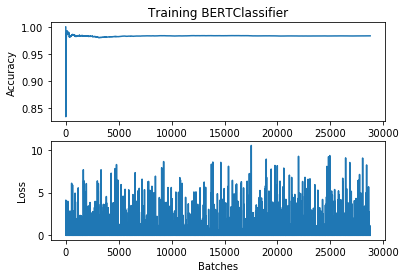

2019-07-20 17:11:36,891 : INFO : wrote 1975 events to disk


Time for [4 - train model]: 4:54:20.292070


In [28]:
run_name = "within_traindev_proepi512_BCE_0.1"
with Timer("4 - train model"), SummaryWriter(logdir="data/" + run_name, flush_secs=600) as sw:
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=5, sw=sw, checkpoint_dir="data/" + run_name)
    model.save_parameters("data/" + run_name + "/bert.model.params")

    plot_train_stats(stats)

In [29]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [30]:
run_name = "within_traindev_proepi512_BCE_0.1"
with Timer("6 - evaluate"), SummaryWriter(logdir="data/" + run_name, flush_secs=60) as sw:
    # model.load_parameters("data/" + run_name + "/bert.model.params", ctx=ctx)
    # bert.model.checkpoint4.params
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2, sw=sw)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier - BCE prolog+epilog 0.1 split", heatmap=False)

2019-07-20 17:11:40,075 : INFO : successfully opened events file: data/within_traindev_proepi512_BCE_0.1/events.out.tfevents.1563635500.cuda
2019-07-20 17:11:40,086 : INFO : wrote 1 event to disk
2019-07-20 17:11:40,087 : INFO : wrote 1 event to disk
2019-07-20 17:12:40,222 : INFO : wrote 836 events to disk
2019-07-20 17:13:40,226 : INFO : wrote 816 events to disk
2019-07-20 17:14:40,247 : INFO : wrote 810 events to disk
2019-07-20 17:15:40,287 : INFO : wrote 824 events to disk
2019-07-20 17:16:40,376 : INFO : wrote 818 events to disk
2019-07-20 17:17:40,420 : INFO : wrote 814 events to disk
2019-07-20 17:18:40,434 : INFO : wrote 858 events to disk



Time for [prediction]: 0:07:45.549373
Accuracy: 0.926302613049601


2019-07-20 17:19:26,129 : INFO : wrote 615 events to disk


Confusion Matrix:
[[2768  191]
 [ 280 3152]]

Accuracy:  0.93 

Report for [BERTClassifier - BCE prolog+epilog 0.1 split]:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2959
           1       0.94      0.92      0.93      3432

    accuracy                           0.93      6391
   macro avg       0.93      0.93      0.93      6391
weighted avg       0.93      0.93      0.93      6391

Time for [6 - evaluate]: 0:07:46.217231


### Train and evaluate each epoch

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=2, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        # stats = train_multi(model, data_train, ctx, metric, loss_function, batch_size=4, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

### Cross topic - Training and evaluating model 

In [31]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df, ratio=0.1)

Time for [1 - test/train split]: 0:00:00.016970


In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [32]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

alcoholism and drug-use are common after abortions.
uncertainty over whether fetuses are "life" should halt abortions.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 25519  1998  4319  1011  2224  2024  2691  2044 11324  2015  1012
     3 12503  2058  3251 10768  5809  2229  2024  1000  2166  1000  2323
  9190 11324  2015  1012     3     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     

In [33]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    #model.load_parameters("data/bert.model.params", ctx=ctx)
    # load model from "within" to evaluate with "cross" test-data
    #model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
    # model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within->cross 0.1 split", heatmap=False)


Time for [prediction]: 0:07:27.403377
Accuracy: 0.9646191646191646
Confusion Matrix:
[[2931   93]
 [ 123 2958]]

Accuracy:  0.96 

Report for [BERTClassifier within->cross 0.1 split]:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3024
           1       0.97      0.96      0.96      3081

    accuracy                           0.96      6105
   macro avg       0.96      0.96      0.96      6105
weighted avg       0.96      0.96      0.96      6105

Time for [6 - evaluate]: 0:07:28.131418


In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model,
                      data_train,
                      ctx,
                      metric,
                      loss_function,
                      batch_size=2,
                      lr=5e-6,
                      num_epochs=epoch_id + 1,
                      checkpoint_dir='data/cross_traindev_proepi512_BCE')
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model,
                                            data_dev,
                                            ctx,
                                            metric,
                                            loss_function,
                                            batch_size=2)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true,
                                y_pred,
                                name="BERTClassifier",
                                heatmap=False)

    model.save_parameters(
        "data/cross_traindev_proepi512_BCE/bert.model.params")

In [ ]:
with Timer("11 - test/train split"):
    # evaluate on "within" test-data
    _, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

with Timer("12 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

with Timer("13 - evaluate"):
    # model from "cross"
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier cross with within", heatmap=False)

---
---

##### Test Cross-Model with Within-Test

5 epochs of cross

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier cross with within", heatmap=False)

```
Time for [prediction]: 0:24:48.940295
Accuracy: 0.8536330916488446
Confusion Matrix:
[[7659 1174]
 [1632 8706]]

Accuracy:  0.85 

Report for [BERTClassifier cross with within]:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      8833
           1       0.88      0.84      0.86     10338

    accuracy                           0.85     19171
   macro avg       0.85      0.85      0.85     19171
weighted avg       0.85      0.85      0.85     19171
```

#### Test Within-Model with Cross-Test

5 epochs of within

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(cross_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("evaluate within with cross"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within with cross", heatmap=False)

```
Time for [prediction]: 0:22:17.542674
Accuracy: 0.9379197379197379
Confusion Matrix:
[[8397  539]
 [ 598 8781]]

Accuracy:  0.94 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      8936
           1       0.94      0.94      0.94      9379

    accuracy                           0.94     18315
   macro avg       0.94      0.94      0.94     18315
weighted avg       0.94      0.94      0.94     18315

Time for [6 - evaluate]: 0:22:19.841677
```

#### Test Within-Model with Within-Test

5 epochs of within

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("evaluate within with within"):
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier within with within", heatmap=False)

```
Time for [prediction]: 0:19:51.733113
Accuracy: 0.9069427781545042
Confusion Matrix:
[[7972  861]
 [ 923 9415]]

Accuracy:  0.91 

Report for [BERTClassifier within with within]:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      8833
           1       0.92      0.91      0.91     10338

    accuracy                           0.91     19171
   macro avg       0.91      0.91      0.91     19171
weighted avg       0.91      0.91      0.91     19171

Time for [evaluate within with cross]: 0:19:52.352049
```

#### Test Cross-Model with Cross-Test

5 epochs of cross

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(cross_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier cross", heatmap=False)

```
Time for [prediction]: 0:23:28.845010
Accuracy: 0.9197925197925197
Confusion Matrix:
[[8329  607]
 [ 862 8517]]

Accuracy:  0.92 

Report for [BERTClassifier cross]:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      8936
           1       0.93      0.91      0.92      9379

    accuracy                           0.92     18315
   macro avg       0.92      0.92      0.92     18315
weighted avg       0.92      0.92      0.92     18315
```

---
---

#### Details to wrong classified arguments

within_traindev

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
_, X_dev, _, y_dev = get_train_test_sets(within_traindev_df)

data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
# print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=2)
print("Accuracy:", metric.get()[1])

y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
report_training_results(y_true, y_pred, name="BERTClassifier within-within", heatmap=False)

In [ ]:
# convert predictions to dataframe
dev_pred_df = pd.DataFrame(data=y_pred, columns=["prediction"], dtype="bool")

# merge all dataframes
dev_df = X_dev.join(y_dev)
dev_df = dev_df.reset_index()
dev_df = pd.merge(dev_df, dev_pred_df, left_index=True, right_index=True, how='inner')
dev_df.set_index('id', inplace=True)

# re-apply tag value
dev_df = dev_df.progress_apply(add_tag, axis=1)
# info
dev_df.info()

In [ ]:
import pickle


dev_df_ser_file = "data/within_traindev_proepi512_BCE/eval_dev_df.pickle"


with open(dev_df_ser_file, "wb") as f:
    pickle.dump(dev_df, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(dev_df_ser_file, "rb") as f:
    dev_df = pickle.load(f)


dev_df.info()

In [ ]:
FPFN_df = dev_df[(dev_df['is_same_side'] != dev_df['prediction'])]  #  and (dev_df['tag'] != 'abortion')
FPFN_df.info()
FPFN_df.head()

In [ ]:
from IPython.display import HTML, display
import re
#import tabulate
#display(HTML(tabulate.tabulate(table, tablefmt='html')))


def print_args(df, idx, add_linebreaks=True):
    row = df.iloc[idx]
    print('IDX: {}, tag: {}, topics: {}'.format(idx, row['tag'], row['topic']))
    print('Is-Same-Side: {}'.format(row['is_same_side']))

    arg1 = row['argument1']
    arg2 = row['argument2']
    if add_linebreaks:
        pat = re.compile(r'(?P<c>(\.|\?|\!|\:)+\"?)')
        arg1 = pat.sub(r'\1<br/>', arg1)
        arg2 = pat.sub(r'\1<br/>', arg2)

    display(HTML('''<table>
        <tr>
            <td style="border-right:1px dashed black;">{arg1}</td>
            <td>{arg2}</td>
        </tr>
    </table>'''.format(arg1=arg1, arg2=arg2)))

In [ ]:
_ = {print_args(FPFN_df, i) for i in range(10)}

In [ ]:
# tokenizer from BERT
def tokenize_arguments(row):
    # tokenize
    row['argument1_tokens'] = tokenizer(row['argument1'])
    row['argument2_tokens'] = tokenizer(row['argument2'])

    # count tokens
    row['argument1_len'] = len(row['argument1_tokens'])
    row['argument2_len'] = len(row['argument2_tokens'])
    # token number diff
    row['argument12_len_diff'] = row['argument1_len'] - row['argument2_len']
    row['argument12_len_diff_abs'] = np.abs(row['argument12_len_diff'])
    return row


FPFN_df = FPFN_df.progress_apply(tokenize_arguments, axis=1)
FPFN_df.describe()

In [ ]:
FPFN_df.plot()

---

# Make final results/predictions

In [ ]:
model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
# model.load_parameters('data/within_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
# model.load_parameters('data/cross_traindev_proepi512_BCE/bert.model.checkpoint4.params', ctx=ctx)
model.load_parameters('data/within_traindev_proepi512_BCE_0.1/bert.model.checkpoint4.params', ctx=ctx)

In [ ]:
X_pred = within_test_df[['argument1', 'argument2', 'topic']]
#X_pred = cross_test_df[['argument1', 'argument2', 'topic']]
y_pred = None

data_pred_raw, data_pred = transform_dataset(X_pred, y_pred, transform)

In [ ]:
# data_pred_raw[0]

In [ ]:
# data_pred[0]

In [ ]:
# label_map=all_labels
predictions = predict_unknown(model, data_pred, ctx, label_map=None, batch_size=1)

In [ ]:
assert len(data_pred) == len(predictions) == len(X_pred)

In [ ]:
# convert predictions to dataframe
# bool works because we mapped 0 to False, 1 to True, is default conversion
test_pred_df = pd.DataFrame(data=predictions, columns=["prediction"], dtype="bool")

# merge all dataframes
# test_df = X_pred.join(y_pred)
test_df = X_pred.reset_index()
test_df = pd.merge(test_df, test_pred_df, left_index=True, right_index=True, how='inner')
test_df.set_index('id', inplace=True)

# re-apply tag value
test_df = test_df.progress_apply(add_tag, axis=1)
# info
test_df.info()

In [ ]:
import pickle

# ser_fn = "data/within_traindev_proepi512_BCE/within_test_pred_df.pickle"
# ser_fn = "data/cross_traindev_proepi512_BCE/cross_test_pred_df.pickle"
# ser_fn = "data/cross_traindev_proepi512_BCE/within_with_cross_model_test_pred_df.pickle"
# ser_fn = "data/within_traindev_proepi512_BCE/cross_with_within_model_test_pred_df.pickle"
ser_fn = "data/within_traindev_proepi512_BCE_0.1/within_test_pred_df.pickle"
# ser_fn = "data/within_traindev_proepi512_BCE_0.1/cross_with_within_model_test_pred_df.pickle"

with open(ser_fn, "wb") as f:
    pickle.dump(test_df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
next(test_df.itertuples())

In [ ]:
# res_fn = "data/within_traindev_proepi512_BCE/within_results.csv"
# res_fn = "data/cross_traindev_proepi512_BCE/cross_results.csv"
# res_fn = "data/cross_traindev_proepi512_BCE/within_with_cross_model_results.csv"
# res_fn = "data/within_traindev_proepi512_BCE/cross_with_within_model_results.csv"
res_fn = "data/within_traindev_proepi512_BCE_0.1/within_results.csv"
# res_fn = "data/within_traindev_proepi512_BCE_0.1/cross_with_within_model_results.csv"

with open(res_fn, "w") as of:
    of.write('"id","label"\n')
    for row_id, row in test_df.iterrows():
        of.write('{},"{}"\n'.format(row_id, str(row['prediction'])))

**NOTE**: do this for within and cross !!!

In [ ]:
# test read
temp_test_df = pd.read_csv("data/within_traindev_proepi512_BCE_0.1/cross_with_within_model_results.csv", index_col='id')
temp_test_df.info()
temp_test_df.iloc[10]